# MCF LP Problem Formulation

## Basic definitions

**Definition**: MCF Net

We define a **net** to be a tuple $(V, E, c, K, D)$ where
    
 - $V$ is a non-empty set of vertices.
 - $G \subseteq V \times V - \{ (v, v) \mid v \in V \}$ is a set of (oriented) edges (self-loops are not included).
 - $c$ is a function $c : E \to \mathbb{R}_{0}^{+}$ which assigns a *capacity* to each edge.
 - $K$ is a set of commodities.
 - $D$ is a set of pairs $(s_i, t_i, d_i)$ for $i \in K$ where:
     - $s_i$ denotes the source node for commodity i
     - $t_i$ denotes the target node for commodity i
     - $d_i$ denotes the demant for commodity i
 
**Definition**: Neighbourhood

For oriented graph $G = (V, E)$ we define for each $v \in V$
$$
\begin{gather*}
N^{+}(v) = \{ u \mid (u, v) \in E \} \\
N^{-}(v) = \{ u \mid (v, u) \in E \}
\end{gather*}
$$
meaning $N^{+}$ is a set of all nodes with an edge comming into $v$ and $N^{-}$ is a set of all nodes for which $v$ has an outcomming edge.

**Definition**: Flow

Let $N = (V, E, c, K, D)$ be a net. Then we define **flow** as a function
$$f : E \times K \to \mathbb{R}^{+}$$
satisfying the following conditions:
 - *the flow does not exceed edge cappacities*
     $$\forall e \in E : \sum\limits_{i \in K} f(e, i) \le c(e)$$
 - *the flow satisfies Kirchhoff's law for each commodity and for all but source and destination nodes*
     $$\forall i \in K : \forall v \in (V - \{s_i, t_i\}) : \sum\limits_{u \in N^{+}(v)} f(uv, i) - \sum\limits_{u \in N^{-}(v)} f(vu, i) = 0$$
     
For simplicity we denote $f_e^k := f(e, k)$.

## LP Formulation

Our formulation will be based on pre-computed maximal flows for each commodity $f^k$. The innitial solution will have the flow on each edge $e$ set as the sum of the flows from each commodity $k$. This can, however, lead to capacities of the edges being violated. We therefore add *violation* variable $\nu_e$ a for each edge $e \in E$ that will represent this violation. We aim to minimize the sum of the violation variables.

In the LP formulation we will have the following **variables**:

 - $f_e^k \in \mathbb{Q}, f_e^k \ge 0$ $\sim$ representing the flow of the commodity $k$ through the edge $e$
 - $\nu_e \in \mathbb{Q}, \nu_e \ge 0$ $\sim$ representing the violation on the edge $e$


**Objective function**
$$ \min \sum_{e \in E} \nu_e$$

**Given the conditions**
    
 - *respecting edge capacities given violation*
 $$\forall e \in E : \sum\limits_{k \in K} f_e^k - \nu_e \le c(e)$$
 - *Kirchhoff's law*
 $$\forall k \in K : \forall v \in (V - \{s_k, t_k\}) :  \sum\limits_{u \in N^{+}(v)} f_{uv}^k - \sum\limits_{u \in N^{-}(v)} f_{vu}^k = 0$$
  
Adding additional variables 


**Objective function**
$$ \max \sum_{e \in E} -\nu_e$$

**Conditions**
$$
\begin{align*}
\forall e \in E &: \sum\limits_{k \in K} f_e^k - \nu_e + \varepsilon_e = c(e) \\
\forall k \in K : \forall v \in (V - \{s_k, t_k\}) &:  \sum\limits_{u \in N^{+}(v)} f_{uv}^k - \sum\limits_{u \in N^{-}(v)} f_{vu}^k = 0 \\
\forall k \in K &: \sum_{\{u, t_k\} \in E} f_{u,t_k}^k = d_k
\end{align*}
$$

**Variables**
$$
\begin{align*}
\forall e \in E : \forall k \in K &: f_e^k \in \mathbb{Q} && f_e^k \ge 0 \\
\forall e \in E &: \nu_e \in \mathbb{Q} && \nu_e \ge 0 \\
\forall e \in E &: \varepsilon_e \in \mathbb{Q} && \varepsilon_e \ge 0
\end{align*}
$$

Denoting $n$ the number of nodes and $m$ the number of edges, we have together $m + |P|n$ conditions and $(|P| + 1)m + (|S| + |D|)|P|$ variables.

In [1]:
# Enable logging
if False:
    import logging

    logging.basicConfig(
        format="%(asctime)s %(levelname)s:%(message)s",
        datefmt="%I:%M:%S",
        level=logging.DEBUG,
    )

### Collecting relevant information from instances

In [2]:
import numpy as np
import sympy as sp
from pathlib import Path
from mcf_simplex_analyzer.load_instance import load_instance
from collections import defaultdict
from fractions import Fraction

from pprint import pprint

# Path to data directory
instances_path = Path("example/")

assert instances_path.exists()

instance_format = "planar"
nod_file = instances_path / (instance_format + ".nod")
arc_file = instances_path / (instance_format + ".arc")
sup_file = instances_path / (instance_format + ".sup")
mut_file = instances_path / (instance_format + ".mut")

instance = load_instance(instance_format, nod_file, arc_file, sup_file, mut_file)
print(instance.info)

InstanceInfo(products_no=92, nodes_no=30, links_no=150, bundled_links_no=150)


In [3]:
# Collect edge capacities
capacities = {}
commodities = set()

for arc in instance.arcs:
    fromnode, tonode, commodity, cost, individual_capacity, mutual_ptr = arc
    if fromnode == -1 or tonode == -1:
        print(arc)
    
    if commodity != -1:
        commodities.add(commodity)
        
    mutual, capacity = capacities.get((fromnode, tonode), (None, None))
    if mutual_ptr > 0:
        mutual = instance.mutual.mapping[mutual_ptr]
    
    if individual_capacity >= 0:
        capacity = capacity + individual_capacity if capacity is not None else individual_capacity
    
    capacities[(fromnode, tonode)] = (mutual, capacity)

# Account for mutual cappacity
for key in capacities:
    mutual, total = capacities[key]
    capacities[key] = max(mutual, total) if mutual is not None and total is not None else total

print(capacities)
print(len(capacities))
print(commodities)

{(1, 14): mpq(48,1), (14, 1): mpq(48,1), (1, 16): mpq(115,1), (16, 1): mpq(115,1), (1, 22): mpq(65,1), (22, 1): mpq(65,1), (1, 26): mpq(86,1), (26, 1): mpq(86,1), (2, 12): mpq(35,1), (12, 2): mpq(35,1), (2, 16): mpq(116,1), (16, 2): mpq(116,1), (2, 19): mpq(42,1), (19, 2): mpq(42,1), (2, 21): mpq(25,1), (21, 2): mpq(25,1), (2, 26): mpq(114,1), (26, 2): mpq(114,1), (3, 17): mpq(80,1), (17, 3): mpq(80,1), (3, 19): mpq(70,1), (19, 3): mpq(70,1), (3, 22): mpq(86,1), (22, 3): mpq(86,1), (3, 24): mpq(105,1), (24, 3): mpq(105,1), (3, 25): mpq(109,1), (25, 3): mpq(109,1), (3, 30): mpq(57,1), (30, 3): mpq(57,1), (4, 11): mpq(97,1), (11, 4): mpq(97,1), (4, 15): mpq(102,1), (15, 4): mpq(102,1), (4, 18): mpq(63,1), (18, 4): mpq(63,1), (4, 23): mpq(103,1), (23, 4): mpq(103,1), (4, 27): mpq(85,1), (27, 4): mpq(85,1), (4, 28): mpq(43,1), (28, 4): mpq(43,1), (5, 7): mpq(107,1), (7, 5): mpq(107,1), (5, 10): mpq(33,1), (10, 5): mpq(33,1), (5, 13): mpq(95,1), (13, 5): mpq(95,1), (5, 23): mpq(38,1), (23, 

In [4]:
# Collect source and destination vertices

source = {}
destination = {}

for supply in instance.supply:
    s, t, k, f = supply
    if k < 0:
        print(supply)
        
    if s == -1:
        destination.setdefault(t, dict())[k] = f
        
    if t == -1:
        source.setdefault(s, dict())[k] = f
        
print(source)
print(destination)

{1: {1: mpq(4,1), 2: mpq(10,1)}, 2: {3: mpq(4,1), 4: mpq(4,1), 5: mpq(9,1)}, 3: {6: mpq(8,1), 7: mpq(9,1)}, 4: {8: mpq(9,1), 9: mpq(4,1), 10: mpq(10,1), 11: mpq(9,1)}, 5: {12: mpq(8,1), 13: mpq(10,1), 14: mpq(11,1)}, 6: {15: mpq(9,1), 16: mpq(9,1), 17: mpq(11,1)}, 7: {18: mpq(11,1), 19: mpq(6,1), 20: mpq(7,1)}, 8: {21: mpq(11,1), 22: mpq(5,1), 23: mpq(4,1), 24: mpq(4,1), 25: mpq(8,1), 26: mpq(7,1), 27: mpq(4,1)}, 9: {28: mpq(4,1), 29: mpq(7,1), 30: mpq(9,1), 31: mpq(6,1)}, 11: {32: mpq(8,1), 33: mpq(11,1), 34: mpq(9,1), 35: mpq(4,1), 36: mpq(7,1), 37: mpq(11,1), 38: mpq(6,1), 39: mpq(5,1)}, 12: {40: mpq(11,1)}, 13: {41: mpq(7,1), 42: mpq(8,1), 43: mpq(6,1)}, 14: {44: mpq(6,1), 45: mpq(6,1), 46: mpq(10,1), 47: mpq(6,1), 48: mpq(6,1), 49: mpq(10,1), 50: mpq(8,1)}, 15: {51: mpq(7,1)}, 16: {52: mpq(8,1), 53: mpq(7,1), 54: mpq(9,1), 55: mpq(9,1), 56: mpq(8,1)}, 17: {57: mpq(11,1), 58: mpq(8,1), 59: mpq(10,1)}, 18: {60: mpq(4,1), 61: mpq(5,1), 62: mpq(5,1)}, 19: {63: mpq(4,1), 64: mpq(8,1)},

In [5]:
in_neighbours = {}
out_neighbours = {}

for arc in instance.arcs:
    fromnode, tonode, _, _, _, _ = arc
    in_neighbours.setdefault(tonode, set()).add(fromnode)
    out_neighbours.setdefault(fromnode, set()).add(tonode)

    
print(in_neighbours)
print(out_neighbours)

{14: {1, 8, 12, 16, 21, 22, 29, 30}, 1: {16, 26, 14, 22}, 16: {1, 2, 14, 21, 26}, 22: {1, 3, 14, 19, 26, 30}, 26: {1, 2, 16, 19, 22}, 12: {2, 21, 14}, 2: {12, 16, 19, 21, 26}, 19: {2, 3, 22, 24, 26}, 21: {16, 2, 12, 14}, 17: {25, 3, 30}, 3: {17, 19, 22, 24, 25, 30}, 24: {19, 3}, 25: {3, 5, 17, 23, 30}, 30: {3, 5, 6, 7, 8, 14, 17, 22, 25}, 11: {9, 28, 4, 20}, 4: {11, 15, 18, 23, 27, 28}, 15: {18, 27, 4, 28}, 18: {27, 4, 15}, 23: {25, 27, 4, 5}, 27: {4, 5, 13, 15, 18, 23, 28}, 28: {4, 6, 8, 10, 11, 13, 15, 20, 27}, 7: {10, 5, 6, 30}, 5: {7, 10, 13, 23, 25, 27, 30}, 10: {5, 6, 7, 13, 28}, 13: {10, 27, 28, 5}, 6: {7, 8, 10, 28, 30}, 8: {6, 14, 20, 28, 29, 30}, 20: {8, 9, 11, 28, 29}, 29: {8, 9, 20, 14}, 9: {11, 20, 29}}
{1: {16, 26, 14, 22}, 14: {1, 8, 12, 16, 21, 22, 29, 30}, 16: {1, 2, 14, 21, 26}, 22: {1, 3, 14, 19, 26, 30}, 26: {1, 2, 16, 19, 22}, 2: {12, 16, 19, 21, 26}, 12: {2, 21, 14}, 19: {2, 3, 22, 24, 26}, 21: {16, 2, 12, 14}, 3: {17, 19, 22, 24, 25, 30}, 17: {25, 3, 30}, 24: {19

# Finding maximal flow for individual commodities

In [6]:
DRAW_GRAPH = False

In [7]:
# Normalize to whole numbers
denoms = ([capacity.denominator for capacity in capacities.values() if capacity is not None] 
          + [ source[s][k].denominator for s in source for k in source[s] ] 
          + [ destination[t][k].denominator for t in destination for k in destination[t] ] 
         )
lcm = np.lcm.reduce(denoms)

# Normalize capacities
for key in capacities:
    capacity = capacities[key]
    if capacity is not None:
        capacities[key] = capacity.numerator * (lcm // capacity.denominator)
        
# Normalize sources
for s in source:
    for k in source[s]:
        supply = source[s][k]
        source[s][k] = supply.numerator * (lcm // supply.denominator)

# Normalize destinations
for t in destination:
    for k in destination[t]:
        demand = destination[t][k]
        destination[t][k] = demand.numerator * (lcm // demand.denominator)
        
network_info = (source, destination, capacities, lcm)

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
for (u, v) in capacities:
    capacity = capacities[(u, v)]
    if capacity is not None:
        graph.add_edge(u, v, capacity=capacity)
    else:
        graph.add_edge(u, v)
        
if DRAW_GRAPH:
    plt.figure(figsize=(13, 8))
    nx.draw_kamada_kawai(graph, node_size=100)

In [9]:
import pprint

def gather_sources(network_info, graph, commodity):
    (source, _, capacities, _) = network_info

    for s in source:
        if commodity in source[s]:
            supply = source[s][commodity].numerator
            graph.add_edge("Source", s, capacity=supply)

            
def gather_destinations(network_info, graph, commodity):
    (_, destination, capacities, _) = network_info
    
    commodity_destinations = []
    for t in destination:
        if commodity in destination[t]: 
            demand = destination[t][commodity]      
            graph.add_edge(t, "Destination", capacity=demand)
            
def get_percantage_full(graph, flow_dict, u, v):
    max_capacity = graph.get_edge_data(u, v).get('capacity', None)
    
    if max_capacity is None:
        return 0
    
    perc = flow_dict[u][v] / max_capacity
    
    return perc

In [10]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def draw_network(graph, flow_dict):
    plt.figure(figsize=(10, 7))
    
    percentage_full=np.array([ float(get_percantage_full(graph, flow_dict, u, v)) for (u,v) in graph.edges])
    norm = Normalize(vmin=0, vmax=1)
    colors = cm.viridis(norm(percentage_full))
    colors[ percentage_full > 1 ] = [1, 0, 0, 1]
    
    
    # DEBUG
    #print(percentage_full)
    
    nx.draw_kamada_kawai(
        graph,
        
        with_labels=True,
        font_size=16,
        font_weight="bold",
        
        node_size=500,
        nodelist=graph.nodes,
        node_color=['lightblue' for _ in graph.nodes],
        
        #edge_color=percentage_full,
        edge_color=colors,
        width=2,
        connectionstyle="arc3,rad=0.1"
    )

MAX_ITER = 4
print(f"Computing first {MAX_ITER} networks ...")

for commodity in range(1, min(instance.info.products_no + 1, MAX_ITER + 1)):
    commodity_graph = graph.copy()
    
    gather_sources(network_info, commodity_graph, commodity)
    gather_destinations(network_info, commodity_graph, commodity)

    # Compute maximal flow     
    flow_value, flow_dict = nx.maximum_flow(commodity_graph, "Source", "Destination")
    
    # DEBUG
    # print(flow_value)
    # print(pprint.pprint(flow_dict))
    
    if DRAW_GRAPH:
        draw_network(commodity_graph, flow_dict)

Computing first 4 networks ...


In [11]:
flow_sum = {}

acc = 0
for commodity in range(1, instance.info.products_no + 1):
    print("Computing flow for commodity", commodity)
    
    commodity_graph = graph.copy()
    
    gather_sources(network_info, commodity_graph, commodity)
    gather_destinations(network_info, commodity_graph, commodity)

    # Compute maximal flow     
    flow_value, flow_dict = nx.maximum_flow(commodity_graph, "Source", "Destination")
    
    for u in flow_dict:
        if u == "Source":
            continue
            
        for v in flow_dict[u]:
            if v == "Destination":
                continue
                
            d = flow_sum.setdefault(u, {})
            d[v] = d.get(v, 0) + flow_dict[u][v]
            
    # DEBUG
    acc += flow_value
    # print(flow_value)
    # print(pprint.pprint(flow_dict))

print(acc)
flow_sum

Computing flow for commodity 1
Computing flow for commodity 2
Computing flow for commodity 3
Computing flow for commodity 4
Computing flow for commodity 5
Computing flow for commodity 6
Computing flow for commodity 7
Computing flow for commodity 8
Computing flow for commodity 9
Computing flow for commodity 10
Computing flow for commodity 11
Computing flow for commodity 12
Computing flow for commodity 13
Computing flow for commodity 14
Computing flow for commodity 15
Computing flow for commodity 16
Computing flow for commodity 17
Computing flow for commodity 18
Computing flow for commodity 19
Computing flow for commodity 20
Computing flow for commodity 21
Computing flow for commodity 22
Computing flow for commodity 23
Computing flow for commodity 24
Computing flow for commodity 25
Computing flow for commodity 26
Computing flow for commodity 27
Computing flow for commodity 28
Computing flow for commodity 29
Computing flow for commodity 30
Computing flow for commodity 31
Computing flow fo

{1: {14: mpz(14), 16: 0, 22: 0, 26: mpz(13)},
 14: {1: mpz(24),
  8: mpz(83),
  12: mpz(12),
  16: mpz(35),
  21: mpz(21),
  22: mpz(64),
  29: mpz(21),
  30: mpz(37)},
 16: {1: 0, 2: mpz(8), 14: mpz(42), 21: 0, 26: 0},
 22: {1: 0, 3: mpz(19), 14: mpz(32), 19: mpz(25), 26: mpz(31), 30: mpz(9)},
 26: {1: 0, 2: mpz(11), 16: 0, 19: 0, 22: mpz(9)},
 2: {12: mpz(11), 16: mpz(9), 19: mpz(4), 21: 0, 26: mpz(4)},
 12: {2: 0, 14: mpz(11), 21: 0},
 19: {2: mpz(19), 3: 0, 22: mpz(32), 24: mpz(4), 26: 0},
 21: {2: 0, 12: 0, 14: mpz(15), 16: 0},
 3: {17: mpz(9), 19: mpz(19), 22: mpz(18), 24: mpz(15), 25: mpz(8), 30: 0},
 17: {3: mpz(11), 25: mpz(18), 30: 0},
 24: {3: 0, 19: mpz(20)},
 25: {3: mpz(37), 5: mpz(32), 17: 0, 23: 0, 30: mpz(4)},
 30: {3: mpz(11),
  5: mpz(18),
  6: 0,
  7: mpz(37),
  8: 0,
  14: mpz(39),
  17: mpz(5),
  22: mpz(38),
  25: mpz(7)},
 4: {11: mpz(24), 15: 0, 18: mpz(20), 23: mpz(26), 27: mpz(5), 28: mpz(25)},
 11: {4: mpz(19), 9: mpz(39), 20: mpz(11), 28: mpz(11)},
 15: {4:

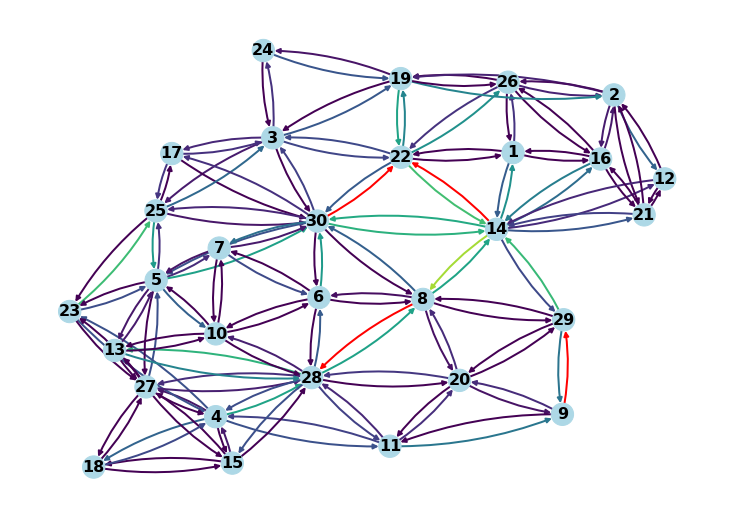

In [12]:
draw_network(graph, flow_sum)

In [13]:
from mcf_simplex_analyzer.formulate import formulate_concurrent_flow_problem

network_info, max_flow_sum = formulate_concurrent_flow_problem(instance)

In [14]:
import pulp
import attr

def solve_for(instance, network_info, y=1):
    model = pulp.LpProblem(name="concurrent_flow", sense=pulp.LpMinimize)

    variables = {"flow": {}, "violation": {}}
    for commodity in range(1, instance.info.products_no + 1):
        for u in network_info.capacities:
            for v in network_info.capacities[u]:
                variables["flow"][(u, v, commodity)] = pulp.LpVariable(
                    name="f_({}-{})^{}".format(u, v, commodity), lowBound=0
                )

    # Violation
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            variables["violation"][(u, v)] = pulp.LpVariable(name="v_({}-{})".format(u, v), lowBound=0)

    # Objective
    model += pulp.lpSum(
        [
            variables["violation"][(u, v)]
            for u in network_info.capacities
            for v in network_info.capacities[u]
        ]
    )

    # Edges
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            model += (
                pulp.lpSum(
                    [
                        variables["flow"][(u, v, commodity)]
                        for commodity in range(1, instance.info.products_no + 1)
                    ]
                )
                - variables["violation"][(u, v)]
                <= network_info.capacities[u][v]
            )

    vertices = set()
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            vertices.add(u)
            vertices.add(v)

    # Kirchhof
    for commodity in range(1, instance.info.products_no + 1):
        for vertex in vertices:
            if vertex in network_info.sources and commodity in network_info.sources[vertex]:
                continue

            if (
                vertex in network_info.destinations
                and commodity in network_info.destinations[vertex]
            ):
                continue

            outgoing = pulp.lpSum(
                [
                    variables["flow"][(vertex, u, commodity)]
                    for u in network_info.capacities.get(vertex, [])
                ]
            )

            incomming = pulp.lpSum(
                [
                    variables["flow"][(u, vertex, commodity)]
                    for u in network_info.capacities
                    if vertex in network_info.capacities.get(u, {})
                ]
            )

            model += outgoing - incomming == 0

    for destination in network_info.destinations:
        for commodity in network_info.destinations[destination]:
            incomming = pulp.lpSum(
                    [
                        variables["flow"][(u, destination, commodity)]
                        for u in network_info.capacities
                        if destination in network_info.capacities.get(u, {})
                    ]
                )
            model += incomming >= y * network_info.destinations[destination][commodity]

    model.solve()
    
    return model, variables
 

In [15]:
y = 1
y_max = None
y_min = 0

eps = 1e-6

# Increase
ys = []
opts = []
while True:
    model, variables = solve_for(instance, network_info, y)
    opt = sum(var.value() for key, var in variables["violation"].items())
    print("opt:", opt)
    ys.append(y)
    opts.append(opt)

    if opt > eps:
        y_max = y
        new_y = (y_min + y_max) / 2

    if abs(opt) <= eps:
        y_min = y
        if y_max is None:
            new_y = 2 * y
        else:
            new_y = (y_min + y_max) / 2
            
    if abs(y - new_y) < 0.1 and opt == 0:
        break
        
    y = new_y

    print("New y:", y)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/davidkubek/.cache/pypoetry/virtualenvs/mcf-simplex-analyzer-RAO3Mfjo-py3.9/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/7707a2975c2e45ad837fec0e27cc8b8b-pulp.mps branch printingOptions all solution /tmp/7707a2975c2e45ad837fec0e27cc8b8b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2823 COLUMNS
At line 43115 RHS
At line 45934 BOUNDS
At line 45935 ENDATA
Problem MODEL has 2818 rows, 13950 columns and 40141 elements
Coin0008I MODEL read with 0 errors
Presolve 2818 (0) rows, 13936 (-14) columns and 40127 (-14) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 1.1027118e-06 ( 0.00011027118%) - largest zero change 1.1027099e-06
0  Obj 0 Primal inf 1830.9999 (106)
131  Obj 0.0013437808 Primal inf 1747.9999 (105)
262  Obj 0.0014230375 Primal inf 919.99991 (94)
393  Obj 0.0016081178 Primal inf 986.99991 (92)
524  Obj 0

In [16]:
ys

[1, 2, 4, 8, 6.0, 5.0, 5.5, 5.75, 5.625]

In [17]:
opts

[0.0, 0.0, 0.0, 383.0, 17.0, 0.0, 0.0, 4.5, 0.0]

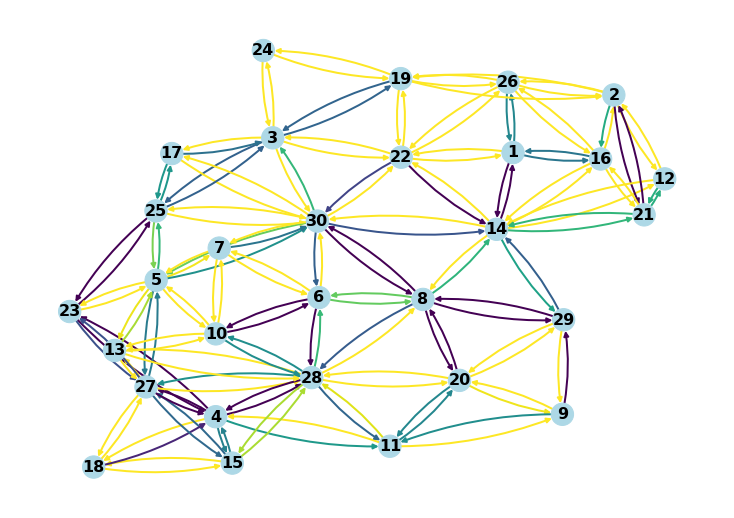

In [18]:
flow_sum = {}
for u in network_info.capacities:
    for v in network_info.capacities[u]:
        flow_sum.setdefault(u, {})[v] = round(
            sum(
                variables["flow"][(u, v, commodity)].value()
                for commodity in range(1, instance.info.products_no + 1)
                if (u, v, commodity) in variables["flow"]
            ),
            4,
        )

for u in flow_sum:
    for v in flow_sum[u]:
        if flow_sum[u][v] > network_info.capacities[u][v]:
            print(u, v, flow_sum[u][v] - network_info.capacities[u][v])

draw_network(graph, flow_sum)

In [19]:
import sympy
from scipy.sparse import lil_matrix

from mcf_simplex_analyzer.fractionarray import FractionArray
from mcf_simplex_analyzer.simplex import LPModel, lp_sum


def formulate_lp(instance, network_info, y=1):
    model = LPModel(name="concurrent_flow")

    variables = {"flow": {}, "violation": {}}
    for commodity in range(1, instance.info.products_no + 1):
        for u in network_info.capacities:
            for v in network_info.capacities[u]:
                variables["flow"][(u, v, commodity)] = model.new_variable(
                    name="f_({}-{})^{}".format(u, v, commodity)
                )

    # Violation
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            variables["violation"][(u, v)] = model.new_variable(
                name="v_({}-{})".format(u, v)
            )

    # Objective
    model.objective_function = lp_sum(
        [
            variables["violation"][(u, v)]
            for u in network_info.capacities
            for v in network_info.capacities[u]
        ]
    )

    # Edges
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            model.constraints.append(
                lp_sum(
                    [
                        variables["flow"][(u, v, commodity)]
                        for commodity in range(1, instance.info.products_no + 1)
                    ]
                )
                - variables["violation"][(u, v)]
                <= network_info.capacities[u][v]
            )

    vertices = set()
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            vertices.add(u)
            vertices.add(v)

    # Kirchhof
    for commodity in range(1, instance.info.products_no + 1):
        for vertex in vertices:
            if (
                vertex in network_info.sources
                and commodity in network_info.sources[vertex]
            ):
                continue

            if (
                vertex in network_info.destinations
                and commodity in network_info.destinations[vertex]
            ):
                continue

            outgoing = lp_sum(
                [
                    variables["flow"][(vertex, u, commodity)]
                    for u in network_info.capacities.get(vertex, [])
                ]
            )

            incomming = lp_sum(
                [
                    variables["flow"][(u, vertex, commodity)]
                    for u in network_info.capacities
                    if vertex in network_info.capacities.get(u, {})
                ]
            )

            model.constraints.append(outgoing - incomming == 0)

    for destination in network_info.destinations:
        for commodity in network_info.destinations[destination]:
            incomming = lp_sum(
                [
                    variables["flow"][(u, destination, commodity)]
                    for u in network_info.capacities
                    if destination in network_info.capacities.get(u, {})
                ]
            )
            model.constraints.append(
                incomming >= y * network_info.destinations[destination][commodity]
            )

    return model, variables

In [20]:
model, variables = formulate_lp(instance, network_info, 1)

In [21]:
len(model.constraints)

2818

In [22]:
from mcf_simplex_analyzer.simplex import RevisedSimplex
#simplex = RevisedSimplex.instantiate(model)
#simplex

In [ ]:
import cProfile
import pstats
from pstats import SortKey

cProfile.run("RevisedSimplex.instantiate(model)", 'restats')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
p = pstats.Stats('restats')
#p.strip_dirs().sort_stats(-1).print_stats()
p.sort_stats(SortKey.CUMULATIVE, SortKey.TIME).print_stats(20)
p